## 2. Data Understanding and Preparation

### 2.1 Research Goal and Operationalization

` ⭐️ TODO`

### 2.2 Data Overview

> We examined the App Store and found that most mental health apps fall under the categories `Gesundeit und Fitness` and `Medizin`, with some also in `Lifestyle`. So, we used SQL&Python to filter the data.

- Number of apps and reviews after filtering.
    - apps: `46324` / 55485 (**83%**)
        - Medizin: `12947`
        - Gesundeit und Fitness: `29917`
        - lifestyle: `3460`
    - reviews: `443945` / 520353 (**85%**)
        - Medizin: `35472`
        - Gesundeit und Fitness: `390203`
        - lifestyle: `18270`
- Brief description of key variables (metadata and text).
    - `⭐️ TODO`

### 2.3 Cleaning and Filtering
- Handle outliers (e.g., extreme prices, extremely low number of ratings).
    - 0 <= `review_average`, `rating` <= 5
    - `review_one`,`review_two`,`review_there`,`review_four`, `review_five`: int & >=0
    - `size`,`price_eur` >= 0
- Check missing values in important variables and decide on imputation vs. dropping.
    - keep: because they carry meaningful information.
        - `iphone_version`、`ipad_version`、`ipod_version`、`mac_version`
        - `privacy_linked`、`privacy_unlinked`、`privacy_tracked`、`privacy_policy_link`
        - `rank_from_pickle`
    - imputation:
        - `privacy_not_collected`: change data type  (`text => boolean`)
        - `price_eur`: base on `price` (`text => float`)
    - dropping: 
        - Apps data without app_reviews record.
        - outliers datas (e.g., extreme prices, extremely low number of ratings).
- Document inclusion criteria and any comparator groups (e.g., medical vs. non-medical apps). 
    - criteria groups: `df_medizin`
    - comparator groups: `df_medizin_not`

In [1]:
# 2. Data Understanding and Preparation
# 2.2 Data Overview
# TODO: Load your datasets here and perform basic checks
from sqlalchemy import create_engine  # use SQLAlchemy connecting to the database
import pandas as pd

# Stored in the `.env` file.  <- Replace it with real params.
host = "localhost"
port = 5432
user = "postgres"
password = 123456
db = "DatenBank"

# connect to the database
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}")
# query the raw data.
query_apps = "SELECT * FROM apple_apps;"
query_reviews = "SELECT * FROM app_reviews;"
apps = pd.read_sql(query_apps, engine)
reviews = pd.read_sql(query_reviews, engine)
# Check the data has been loaded correctly.
apps.head()
reviews.head()

,review_id,app_id,date,developerresponse,review,rating,isedited,username,title
0,1,1000017994,2022-08-30 06:46:56,"{""id"": 32104844, ""body"": ""Ich hoffe euch geht ...",Danke finde das Programm sehr gut habe da ich ...,4,False,gelpe,Leider nicht in deutsch
1,2,1000017994,2017-10-03 21:38:05,,Cardiogram ist meiner Meinung nach die beste P...,5,False,dr_ben,Must have
2,3,1000017994,2018-04-29 18:44:59,,"Leider nur auf Englisch, trotzdem 5*",5,False,Ludo374,Optimal mit Iwatch
3,4,1000017994,2017-11-20 05:44:46,,Nutze sie seid 2 Wochen und bin bisher sehr zu...,4,False,Lars Engmann,Cardiogram App
4,5,1000017994,2021-04-28 06:29:27,"{""id"": 22490197, ""body"": ""Hi axolotta, I'm sor...",Ich kann meine Bewertung deshalb auch wieder n...,5,True,axolotta,Problem schnell behoben


In [ ]:
# TODO: basic checks missing values (NULL)
reviews.isna().sum()         # all's good
apps.isna().sum()            # rank_from_pickle has 54839 NULL, but is meaningful => keep!

In [ ]:
# TODO: basic checks missing values (0)
(reviews == 0).sum()     # all matching data is `int | boolean` => keep!
(apps == 0).sum()        # all matching data is `int | boolean` => keep!

In [ ]:
# check visualize missing data (raw)
import missingno as msno
import matplotlib.pyplot as plt

df = reviews.merge(apps, on="app_id", how="left")
msno.matrix(df)
plt.show()

In [ ]:
# Check the data types to prepare for further data cleaning. (38 items)
df_medizin.dtypes.to_frame(name="dtype").reset_index(names="") 

In [ ]:
import numpy as np

# TODO: mark empty string values ("") as missing values (NULL).
for _df in (apps, reviews):
    obj_cols = _df.select_dtypes(include=["object", "string"]).columns
    if len(obj_cols):
        _df[obj_cols] = _df[obj_cols].replace('', np.nan)

# TODO: imputation the date if need.
apps['privacy_not_collected_bool'] = (
    apps['privacy_not_collected']
        .astype(str)
        .str.strip() # 去两端空白
        .str.lower() # 统一转为小写
        .eq('true')  # 判断条件
)
# print(apps['privacy_not_collected'].value_counts(dropna=False))   # check result (也包括NULL值)
apps['price_eur'] = (
    apps['price']
        .astype(str)
        .str.replace('\xa0', '', regex=False)   # delete ' '
        .str.replace('€', '', regex=False)      # delete €
        .str.replace(',', '.', regex=False)     # , => .
        .str.strip()                            # 去两端空白
)
# print(apps['price_eur'].head(10)) # check result

# TODO: Handle outliers data.
cols_0 = ['size']
cols_int_0 = ['review_one', 'review_two', 'review_three', 'review_four', 'review_five']
apps = apps[
    apps['review_average'].between(0, 5, inclusive='both') &  # 0<= Each <=5
    (apps[cols_0] > 0).all(axis=1) &                          # Each >0
    (apps[cols_int_0] >= 0).all(axis=1) &                      # Each >0
    (apps[cols_int_0] % 1 == 0).all(axis=1)                   # only integer values;
]
reviews = reviews[
    reviews['rating'].between(0, 5, inclusive='both')         # 0<= Each <=5
]

# apps 表中的 review_count 和实际 reviews 表中的数据统计不符，进行统一（先聚合再map）
# 1️⃣ 只在 reviews 表中计算「app_id → 评论数」的映射
review_count_map = reviews["app_id"].value_counts()
# 2️⃣ 映射到 apps 表（临时中转）
apps["review_count"] = (
    apps["app_id"]
    .map(review_count_map)
    .fillna(0)
    .astype(int)
)

# 拆分实验组和对照组
categories_medizin = {
    "Medizin",
    "Gesundheit und Fitness",
    "Lifestyle"
}
# 拆分 apps 表
apps_medizin = apps[apps["category"].isin(categories_medizin)].copy()
apps_medizin_not = apps[~apps["category"].isin(categories_medizin)].copy()
# 获取 A / B 组的 app_id (用 set 查找更快、语义更清楚)
app_ids_medizin = set(apps_medizin["app_id"])
app_ids_medizin_not = set(apps_medizin_not["app_id"])
# 按 app_id 拆分 reviews 表（关键）
reviews_medizin = reviews[reviews["app_id"].isin(app_ids_medizin)].copy()
reviews_medizin_not = reviews[reviews["app_id"].isin(app_ids_medizin_not)].copy()

# check the shape of data A & B
print(
    "apps             – Anzahl Zeilen:", apps.shape[0], "\n" 
    "apps_medizin     – Anzahl Zeilen:", apps_medizin.shape[0], round(apps_medizin.shape[0]*100 / apps.shape[0], 2), "% \n" 
    "apps_medizin_not – Anzahl Zeilen:", apps_medizin_not.shape[0], round(apps_medizin_not.shape[0]*100 / apps.shape[0], 2), "%"
)
print(
    "reviews             – Anzahl Zeilen:", reviews.shape[0], "\n" 
    "reviews_medizin     – Anzahl Zeilen:", reviews_medizin.shape[0], round(reviews_medizin.shape[0]*100 / reviews.shape[0], 2), "% \n"  
    "reviews_medizin_not – Anzahl Zeilen:", reviews_medizin_not.shape[0], round(reviews_medizin_not.shape[0]*100 / reviews.shape[0], 2), "%"
)
print("apps – Anzahl Spalten:", apps.shape[1])
print("reviews – Anzahl Spalten:", reviews.shape[1])

apps             – Anzahl Zeilen: 55485 
apps_medizin     – Anzahl Zeilen: 46324 83.49 % 
apps_medizin_not – Anzahl Zeilen: 9161 16.51 %
reviews             – Anzahl Zeilen: 520353 
reviews_medizin     – Anzahl Zeilen: 443945 85.32 % 
reviews_medizin_not – Anzahl Zeilen: 71303 13.7 %
apps – Anzahl Spalten: 32
reviews – Anzahl Spalten: 9


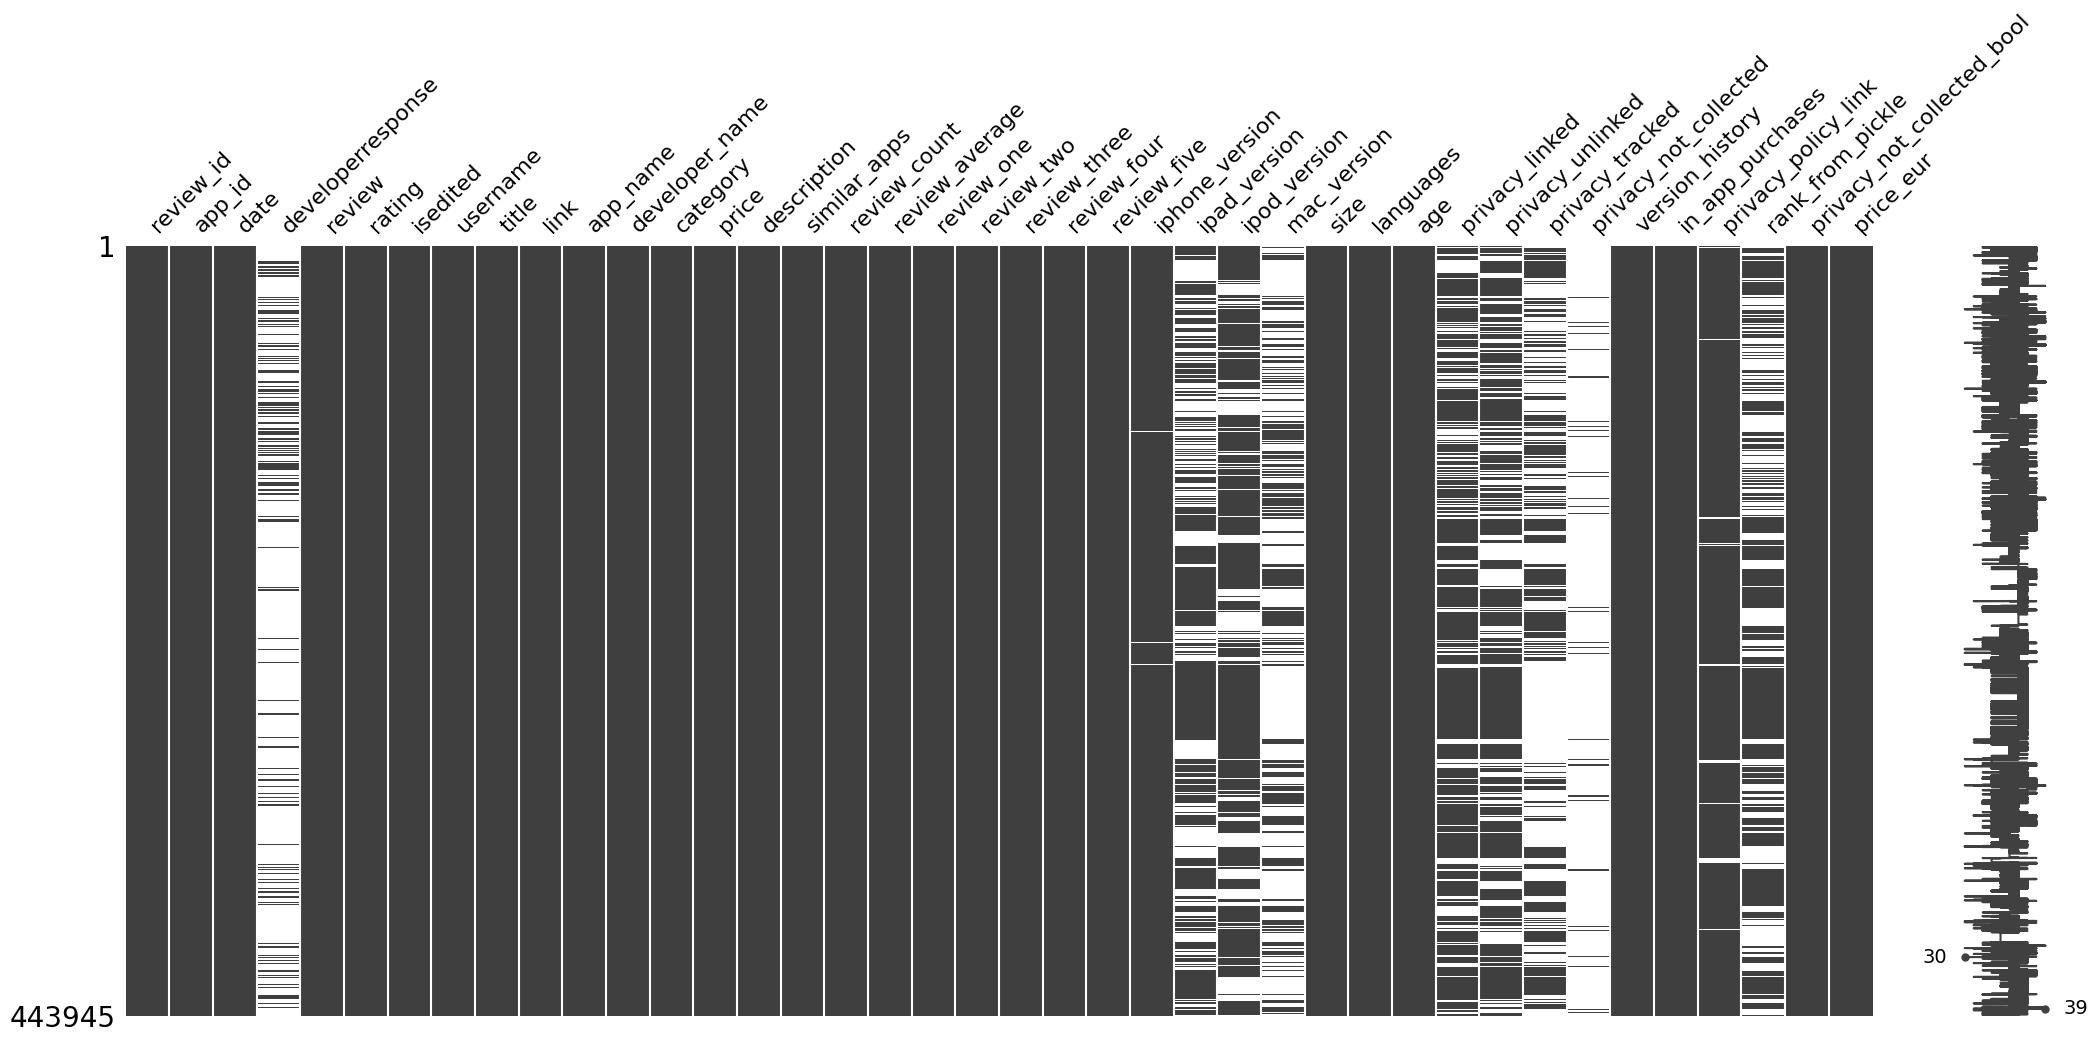

In [3]:
# check visualize missing data (cleaned)
import missingno as msno
import matplotlib.pyplot as plt

# Group=A
df_medizin = reviews_medizin.merge(apps_medizin, on="app_id", how="left")
# Group-B
df_medizin_not = reviews_medizin_not.merge(apps_medizin_not, on="app_id", how="left")
msno.matrix(df_medizin)
plt.show()

## 3. Data Exploration

- Explore distributions of ratings, number of ratings, prices, categories, etc.
- Visualize relevant relationships (e.g., rating vs. price, rating vs. category).
- Use basic text mining on reviews: word frequencies, simple sentiment or topic structure.
- Create and justify **new features** that may help prediction (e.g., sentiment score, review length, price bins).
- Comment on what these patterns suggest about app quality.

In [ ]:
# 本地数据备用，可以从这里开始
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

apps_medizin = pd.read_csv('db/apps_medizin.csv')
reviews_medizin = pd.read_csv('db/reviews_medizin.csv')
apps_medizin_not = pd.read_csv('db/apps_medizin_not.csv')
reviews_medizin_not = pd.read_csv('db/reviews_medizin_not.csv')

# Group=A
df_medizin = reviews_medizin.merge(apps_medizin, on="app_id", how="left")
# Group-B
df_medizin_not = reviews_medizin_not.merge(apps_medizin_not, on="app_id", how="left")

msno.matrix(df_medizin)
plt.show()

In [ ]:
# 查看符合条件的 apps 数量（remove duplicates）
import pandas as pd

num_apps = apps_medizin.shape[0]
num_apps_nunique = df_medizin["app_id"].nunique()

print(f"""
    Total apps: {num_apps},
    Remaining apps: {num_apps_nunique} ({round(num_apps_nunique*100/num_apps,2)}%)
""")

In [6]:
import seaborn as sns

# df_medizin.sort_values(by="review_count", ascending=False).head(10)
df_medizin = (
    df_medizin[df_medizin["review_count"] > 0]
    .drop_duplicates(subset="app_id", keep="first")
    .copy()
)
df_medizin.sort_values(by="review_count", ascending=False)[["app_id", "app_name", "review_count"]].head(10)

,app_id,app_name,review_count
220677,447374873,komoot - Wandern und Radfahren,41281
4206,386022579,Schwangerschaft & Baby App,12151
407012,946099227,YAZIO: Kalorien Zähler & Diät,9646
133931,331308914,WeightWatchers Programm,9254
133678,320606217,Sleep Cycle - Schlaf Aufnahme,8256
243740,462638897,Fitbit – Gesundheit & Fitness,8024
60245,1406830270,Meine AOK,7871
1052,1037595083,StepsApp Schrittzähler,7159
331508,583446403,Garmin Connect™,7081
135419,341232718,MyFitnessPal: Kalorien Tracker,6914


In [ ]:

import seaborn as sns

df_medizin.sort_values(by="review_count", ascending=False).head(10)

# We need to remove duplicates.



# Following are basic matplotlib plots for distributions and different plots for exploring data and new plots
#

# -----------------------------
# 3.1 Distributions
# -----------------------------
# Histogram: Average Rating
plt.figure(figsize=(8,5))
sns.histplot(df_filtered["review_average"], bins=20, kde=True)
plt.title("Distribution of Average App Ratings")
plt.xlabel("Average Rating (1-5)")
plt.ylabel("Number of Apps")
plt.show()

# Boxplot: Review Count with log scale (nicer sight)
plt.figure(figsize=(8,5))
sns.boxplot(x=df_filtered["review_count"])
plt.xscale("log")
plt.title("Distribution of Review Counts (Log Scale)")
plt.xlabel("Review Count (log scale)")
plt.show()

# Price distribution (for paid apps)
# paid_apps = df_filtered[df_filtered["price_eur"] > 0]
# if not paid_apps.empty:
#     plt.figure(figsize=(8,5))
#     sns.violinplot(x=paid_apps["price_eur"], inner="quartile")
#     plt.title("Price Distribution of Paid Apps")
#     plt.xlabel("Price (€)")
#     plt.xlim(0, 30)
#     plt.show()

# Top categories distributions
# plt.figure(figsize=(8,5))
# top_cats = df_filtered["category"].value_counts().nlargest(3).index
# sns.countplot(y="category", data=df_filtered, order=top_cats)
# plt.title("Top App Categories")
# plt.xlabel("Number of Apps")
# plt.ylabel("")
# plt.show()


# -----------------------------
# 3.2 Relationships
# -----------------------------
# Free vs Paid apps
# df_filtered["is_free"] = df_filtered["price_eur"] == 0
# plt.figure(figsize=(8,5))
# sns.boxplot(x="is_free", y="review_average", data=df_filtered)
# plt.title("Average Rating: Free vs Paid Apps")
# plt.xticks([0,1], ["Paid", "Free"])
# plt.ylabel("Average Rating")
# plt.show()

# Categories relations based on review average
# top = df_filtered["category"].value_counts().nlargest(3).index
# subset_top = df_filtered[df_filtered["category"].isin(top)]
# plt.figure(figsize=(8,5))
# sns.violinplot(x="category", y="review_average", data=subset_top, order=top)
# plt.title("Rating Distribution by the 3 categories")
# plt.ylabel("Average Rating")
# plt.xlabel("")
# plt.show()

In [ ]:
# Dropping all apps without reviews (s. 2.3)
df_filtered = (
    df_filtered[df_filtered["review_count"] >= 0]
    .drop_duplicates(subset="app_id", keep="first")
    .copy()
)
# Number of remaining apps after initial filtering and dropping
num_apps = df_filtered["app_id"].nunique()
print("No. of remaining apps:", len(df_filtered))


In [ ]:
# Dropping all apps without reviews (s. 2.3)
df_filtered = df[(df["review_count"] >= 0) & (df["review"].notna()) & (df["review"].str.strip() != "")].copy()


# Number of remaining apps after initial filtering and dropping
num_apps = df_filtered["app_id"].nunique()
print("No. of remaining apps:", len(df_filtered), num_apps)
